# Modelo de optimización de horarios de cursada simplificado:

In [147]:
import pulp
import numpy.random as rnd
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import pandas

#====> MODELO DE OPTIMIZACIÓN
lp = pulp.LpProblem("matching_cursos", pulp.LpMaximize)

#====> PARÁMETROS
# Nota: Acá hay oportunidad de mejora con técnicas de estadística, ya que fue considerada una distribución 
# uniforme y eso no es real.

num_materias = 10
num_alumnos = 50
##########
max_t_cursada = 8
max_mat_desapr = 10
num_modulos = 60

# Cálculo de peso académico:
# Cantidad de materias aprobadas:
cma_vector = rnd.randint(num_materias + 1, size = num_alumnos)
# Años de antiguedad en la facultad:
aa_vector = rnd.randint(max_t_cursada + 1, size = num_alumnos)
# Cantidad de materias desaprobadas:
cmd_vector = rnd.randint(max_mat_desapr + 1, size = num_alumnos)
# Vector de peso académico:
peso_alumno = 11 * cma_vector + 5 * aa_vector + 3 * cmd_vector

# Nota: En realidad, dada que todas las distribuciones se consideraron uniformes, el peso
# también es uniforme y si ese supuesto fuera cierto, podría directamente calcularse
# el peso como una uniforme. Este supuesto debe estudiarse en profundidad.

# Cálculo de capacidad máxima por curso:
q_curso = rnd.randint(low=25, high=50, size=num_materias)

# Horarios de cada materia (aleatorios):
horarios = np.zeros((num_materias, num_modulos))
for c in range(0, num_materias):
    n_modulos_por_bloque = rnd.randint(low=1, high=4)
    n_bloques = rnd.randint(low=1, high=4)
    rnd_module = rnd.randint(num_modulos-n_modulos_por_bloque, size=n_bloques)

    for inicio_bloque in rnd_module:
        horarios[c, inicio_bloque:inicio_bloque+2] = 1

# Requerimientos de cursada de cada alumno:
req = rnd.choice([1, 0], size=(num_alumnos, num_materias), p=[1/6, 5/6])

#====> SETS
a_set = list(range(0, num_alumnos))
c_set = list(range(0, num_materias))
m_set = list(range(0, num_modulos))

#====> VARIABLES
X = pulp.LpVariable.dicts('X', (a_set, c_set), 0, 1, cat='Binary') # Variable de asignación alumno 'a' a curso 'c'.

#====> FUNCIÓN OBJETIVO
Z = [peso_alumno[a] * X[a][c] for a in a_set for c in c_set]
lp += pulp.lpSum(pulp.lpSum(Z)), 'Z'

# #====> RESTRICCIONES
## Suma de alumnos asignados al curso 'c' menor o igual a su capacidad:
for c in c_set:
    lp += pulp.lpSum([X[a][c] for a in a_set]) <= q_curso[c]
    
## Requerimiento del alumno 'c' al curso 'a' relacionado a la decisión de la variable:
for a in a_set: 
    for c in c_set:
        lp += X[a][c] <= req[a][c]
    
## Los módulos de cáda alumno solo pueden ser ocupados por una materia.
for a in a_set:
    for m in m_set:
        lp += pulp.lpSum([horarios[c][m] * X[a][c] for c in c_set]) <= 1

#====> SOLUCIÓN
lp.solve()
print(pulp.LpStatus[lp.status])

# for variable in lp.variables():
#     print("%s = %.2f" % (variable.name, variable.varValue))
# print(pulp.value(lp.objective))

Optimal


# Gráfico de horarios para tres alumnos aleatorios:

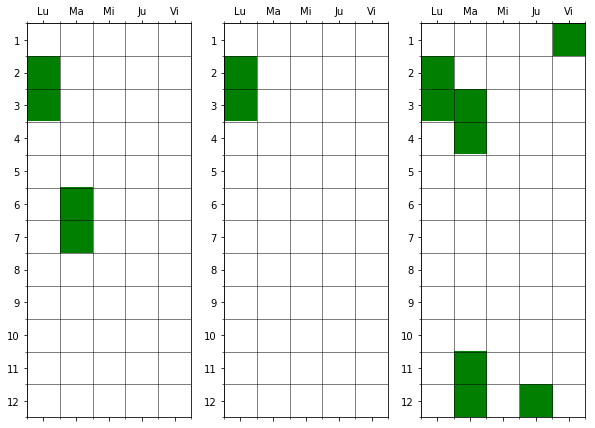

In [148]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

fig, axs = plt.subplots(1, 3, figsize=(10, 20))
fig.subplots_adjust(hspace = .5, wspace=0.2)

for ax, alumno in zip(axs, rnd.choice(a_set, 3, replace=False)):
    aa = np.zeros((num_modulos))
    for c in c_set:
        if X[alumno][c].varValue:
            aa = aa + horarios[c]
    aa_array = np.array(aa)

    # Mostrar matriz:
    ax.matshow(aa_array.reshape((5, 12)).transpose(), cmap=ListedColormap(['w', 'g']))
    
    # Major ticks
    ax.set_xticks(np.arange(0, 5, 1));
    ax.set_yticks(np.arange(0, 12, 1));

    # Labels for major ticks
    dias = ['Lu', 'Ma', 'Mi', 'Ju', 'Vi']
    ax.set_xticklabels(dias)
    ax.set_yticklabels(np.arange(1, 13, 1));

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 5, 1), minor=True);
    ax.set_yticks(np.arange(-.5, 12, 1), minor=True);
    
    ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

plt.show()